In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [2]:
# Define params
symbols = ['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL']
start_date = datetime(2017, 1, 1, tzinfo=pytz.utc)
end_date = datetime.utcnow()
num_tests = 2000

vbt.settings.returns['year_freq'] = '252 days'

In [3]:
yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)

print(yfdata.symbols)

['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL']


In [4]:
ohlcv = yfdata.concat()

print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])


In [5]:
price = ohlcv['Close']

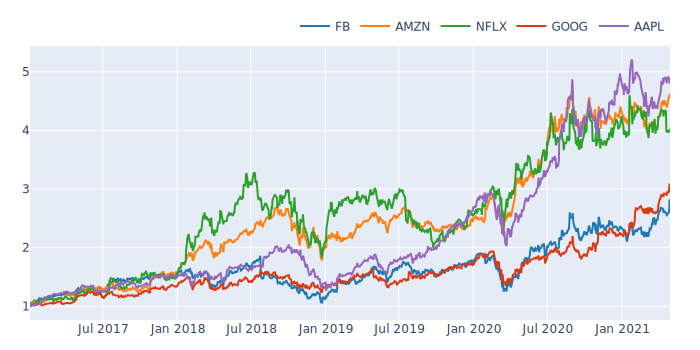

In [6]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_svg()

In [7]:
returns = price.pct_change()

In [8]:
print(returns.mean())

symbol
FB      0.001172
AMZN    0.001584
NFLX    0.001596
GOOG    0.001185
AAPL    0.001638
dtype: float64


In [9]:
print(returns.std())

symbol
FB      0.021389
AMZN    0.019044
NFLX    0.025165
GOOG    0.017583
AAPL    0.019892
dtype: float64


In [10]:
print(returns.corr())

symbol        FB      AMZN      NFLX      GOOG      AAPL
symbol                                                  
FB      1.000000  0.632891  0.500818  0.695088  0.615038
AMZN    0.632891  1.000000  0.636070  0.675241  0.643256
NFLX    0.500818  0.636070  1.000000  0.539419  0.487554
GOOG    0.695088  0.675241  0.539419  1.000000  0.664432
AAPL    0.615038  0.643256  0.487554  0.664432  1.000000


## vectorbt: Random search

### One-time allocation

In [11]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [12]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.13319702814025883,    0,   'FB'),
            ( 0.33810081711389406,    0, 'AMZN'),
            ( 0.26031768763785473,    0, 'NFLX'),
            (  0.2128998389048247,    0, 'GOOG'),
            ( 0.05548462820316767,    0, 'AAPL'),
            ( 0.06528491964469331,    1,   'FB'),
            ( 0.02430844330237927,    1, 'AMZN'),
            (  0.3625014516740258,    1, 'NFLX'),
            (  0.2515713061862386,    1, 'GOOG'),
            ( 0.29633387919266296,    1, 'AAPL'),
            ...
            (  0.2056564359049325, 1998,   'FB'),
            ( 0.14846396871443943, 1998, 'AMZN'),
            ( 0.21512097636364197, 1998, 'NFLX'),
            (  0.3738566007394396, 1998, 'GOOG'),
            (0.056902018277546554, 1998, 'AAPL'),
            ( 0.25860265182212094, 1999,   'FB'),
            (  0.2706191852849979, 1999, 'AMZN'),
            (  0.2854538191129893, 1999, 'NFLX'),
            ( 0.11985160754099378, 1999, 'GOOG'),
            (  0.0654727362388982,

In [13]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(1089, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [14]:
%%time
# Run simulation
portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(portfolio.orders))

10000
CPU times: user 252 ms, sys: 22.7 ms, total: 274 ms
Wall time: 281 ms


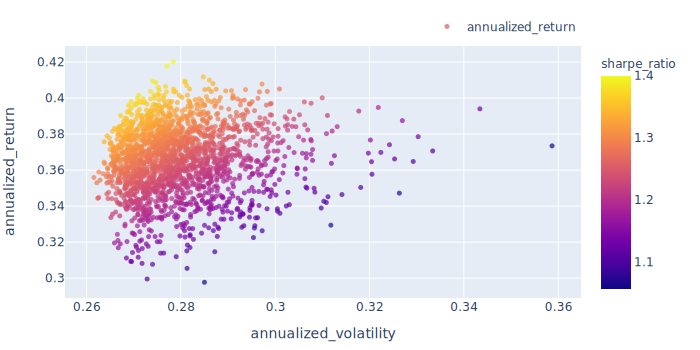

In [15]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = portfolio.annualized_return()
annualized_return.index = portfolio.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=portfolio.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [16]:
# Get index of the best group according to the target metric
best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(best_symbol_group)

1920


In [17]:
# Print best weights
print(weights[best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [18]:
# Compute default stats
print(portfolio.iloc[best_symbol_group].stats())

Start                            2017-01-03 00:00:00
End                              2021-04-30 00:00:00
Duration                          1089 days 00:00:00
Init. Cash                                       100
Total Profit                                 355.358
Total Return [%]                             355.358
Benchmark Return [%]                         285.263
Position Coverage [%]                            100
Max. Drawdown [%]                            34.4419
Avg. Drawdown [%]                             3.0656
Max. Drawdown Duration             324 days 00:00:00
Avg. Drawdown Duration    14 days 01:23:28.695652174
Num. Trades                                        5
Win Rate [%]                                     100
Best Trade [%]                               378.734
Worst Trade [%]                              178.179
Avg. Trade [%]                               285.263
Max. Trade Duration               1088 days 00:00:00
Avg. Trade Duration               1088 days 00

### Rebalance monthly

In [19]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('m').duplicated()

print(rb_mask.sum())

52


In [20]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(1089, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [21]:
%%time

# Run simulation, with rebalancing monthly
rb_portfolio = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto',  # important: sell before buy
    freq='D',
    incl_unrealized=True
)

print(len(rb_portfolio.orders))

519993
CPU times: user 311 ms, sys: 8.7 ms, total: 320 ms
Wall time: 318 ms


In [22]:
rb_best_symbol_group = portfolio.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

1920


In [23]:
print(weights[rb_best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [24]:
print(rb_portfolio.iloc[rb_best_symbol_group].stats())

Start                            2017-01-03 00:00:00
End                              2021-04-30 00:00:00
Duration                          1089 days 00:00:00
Init. Cash                                       100
Total Profit                                 376.527
Total Return [%]                             376.527
Benchmark Return [%]                         285.263
Position Coverage [%]                            100
Max. Drawdown [%]                            33.6883
Avg. Drawdown [%]                            2.94252
Max. Drawdown Duration             304 days 00:00:00
Avg. Drawdown Duration    13 days 01:17:50.270270270
Num. Trades                                      120
Win Rate [%]                                 99.1667
Best Trade [%]                               249.176
Worst Trade [%]                             -7.13426
Avg. Trade [%]                                66.742
Max. Trade Duration               1088 days 00:00:00
Avg. Trade Duration                561 days 09

In [18]:
def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_holding_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    (rb_holding_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        ),
        shapes=[dict(
            xref='x',
            yref='paper',
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            line_color=vbt.settings.layout['template']['layout']['plot_bgcolor']
        ) for date in price.index[rb_idxs]]
    ).show_svg()

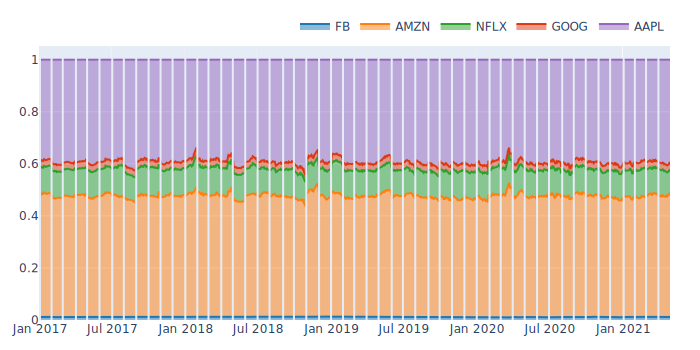

In [26]:
plot_allocation(rb_portfolio.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [11]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def prep_func_nb(c, every_nth):
    # Define rebalancing days
    c.active_mask[:, :] = False
    c.active_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def segment_prep_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)
    
    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=c.close[c.i, c.col]
    )

In [12]:
ann_factor = returns.vbt.returns(freq='D').ann_factor

In [29]:
%%time
# Run simulation using a custom order function
srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 4.62 s, sys: 41.7 ms, total: 4.66 s
Wall time: 4.67 s


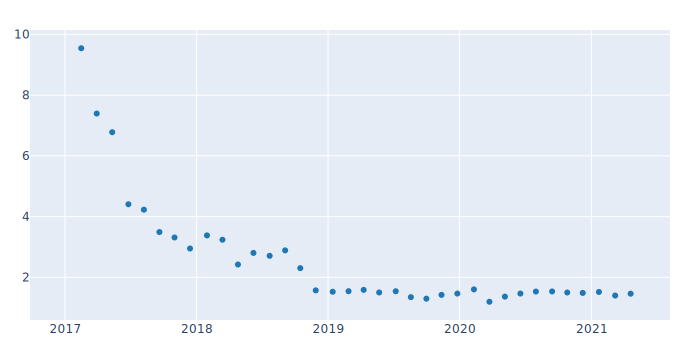

In [30]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [31]:
print(srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-04-30 00:00:00
Duration                           1089 days 00:00:00
Init. Cash                                        100
Total Profit                                  211.789
Total Return [%]                              211.789
Benchmark Return [%]                          285.263
Position Coverage [%]                         97.2452
Max. Drawdown [%]                             34.3509
Avg. Drawdown [%]                             3.44458
Max. Drawdown Duration              311 days 00:00:00
Avg. Drawdown Duration     16 days 03:08:51.147540983
Num. Trades                                        95
Win Rate [%]                                  81.0526
Best Trade [%]                                77.0805
Worst Trade [%]                              -23.7438
Avg. Trade [%]                                13.8981
Max. Trade Duration                1058 days 00:00:00
Avg. Trade Duration       55

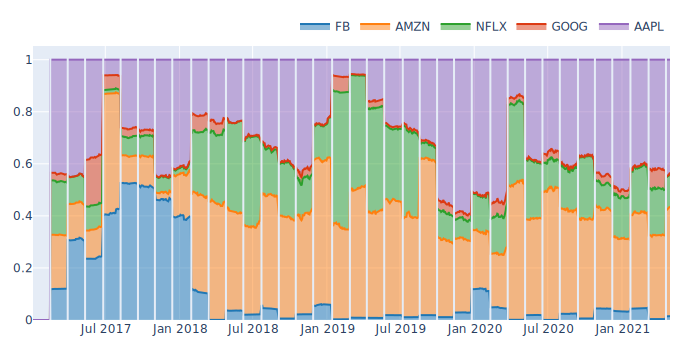

In [32]:
plot_allocation(srb_portfolio)

You can see how weights stabilize themselves with growing data.

In [33]:
%%time
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 36.9 ms, sys: 623 µs, total: 37.5 ms
Wall time: 37.1 ms


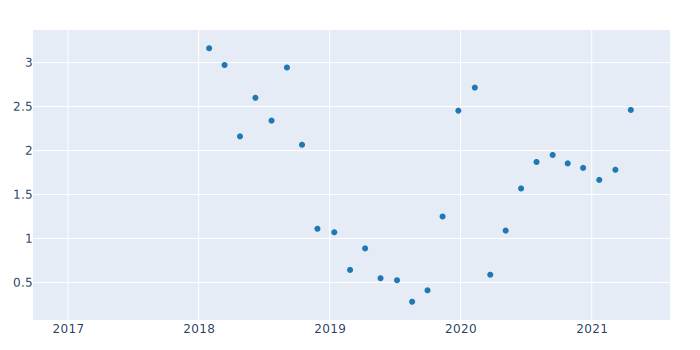

In [34]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [35]:
print(srb252_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-04-30 00:00:00
Duration                           1089 days 00:00:00
Init. Cash                                        100
Total Profit                                  139.614
Total Return [%]                              139.614
Benchmark Return [%]                          285.263
Position Coverage [%]                         75.2066
Max. Drawdown [%]                              33.136
Avg. Drawdown [%]                             4.06421
Max. Drawdown Duration              193 days 00:00:00
Avg. Drawdown Duration     15 days 19:06:07.346938775
Num. Trades                                        65
Win Rate [%]                                  70.7692
Best Trade [%]                                89.0979
Worst Trade [%]                              -15.5016
Avg. Trade [%]                                9.62029
Max. Trade Duration                 818 days 00:00:00
Avg. Trade Duration       46

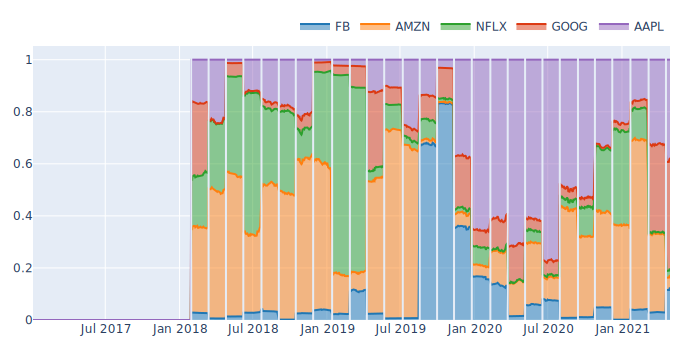

In [36]:
plot_allocation(srb252_portfolio)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [37]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.52415 0.      0.      0.47585]


In [38]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(1089, 5)


In [39]:
%%time
# Run simulation with weights from PyPortfolioOpt
pyopt_portfolio = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
)

print(len(pyopt_portfolio.orders))

2
CPU times: user 15.1 ms, sys: 1.27 ms, total: 16.4 ms
Wall time: 15.9 ms


Faster than stacking solution, but doesn't let you compare weights.

In [40]:
print(pyopt_portfolio.stats())

Start                            2017-01-03 00:00:00
End                              2021-04-30 00:00:00
Duration                          1089 days 00:00:00
Init. Cash                                       100
Total Profit                                 368.952
Total Return [%]                             368.952
Benchmark Return [%]                         285.263
Position Coverage [%]                             40
Max. Drawdown [%]                             34.659
Avg. Drawdown [%]                            3.11311
Max. Drawdown Duration             310 days 00:00:00
Avg. Drawdown Duration    14 days 03:28:41.739130434
Num. Trades                                        2
Win Rate [%]                                     100
Best Trade [%]                               378.734
Worst Trade [%]                              360.071
Avg. Trade [%]                               369.403
Max. Trade Duration               1088 days 00:00:00
Avg. Trade Duration               1088 days 00

### Search and rebalance monthly

**NOTE:** PyPortfolioOpt cannot run within Numba, so restart the notebook and disable Numba in the first cell.

In [13]:
def pyopt_find_weights(sc, price, num_tests):
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [14]:
%%time
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function (Numba should be disabled)
pyopt_srb_portfolio = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 344 ms, sys: 8.28 ms, total: 352 ms
Wall time: 350 ms


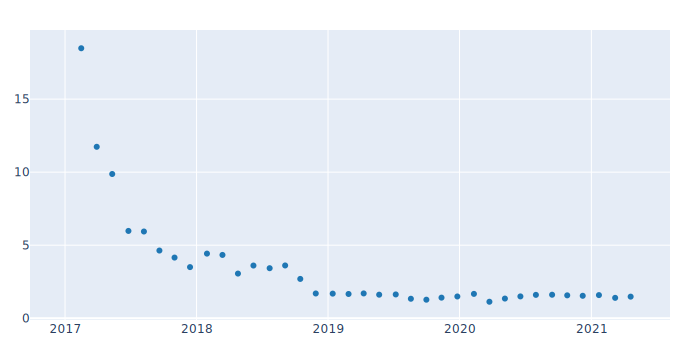

In [15]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [16]:
print(pyopt_srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-04-30 00:00:00
Duration                           1089 days 00:00:00
Init. Cash                                        100
Total Profit                                  180.868
Total Return [%]                              180.868
Benchmark Return [%]                          285.263
Position Coverage [%]                         57.7961
Max. Drawdown [%]                             35.3639
Avg. Drawdown [%]                             3.80372
Max. Drawdown Duration              348 days 00:00:00
Avg. Drawdown Duration     17 days 20:34:17.142857143
Num. Trades                                        62
Win Rate [%]                                  85.4839
Best Trade [%]                                65.4084
Worst Trade [%]                              -30.6354
Avg. Trade [%]                                17.3622
Max. Trade Duration                 848 days 00:00:00
Avg. Trade Duration       26

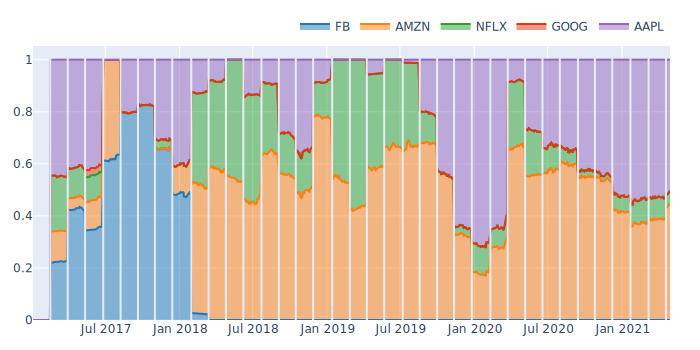

In [19]:
plot_allocation(pyopt_srb_portfolio)